<a href="https://colab.research.google.com/github/Eran-BA/My-Projects/blob/master/Intango_task_Eran_main_last.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Predicting Clicks project**

*made by Eran Ben Artzy!*

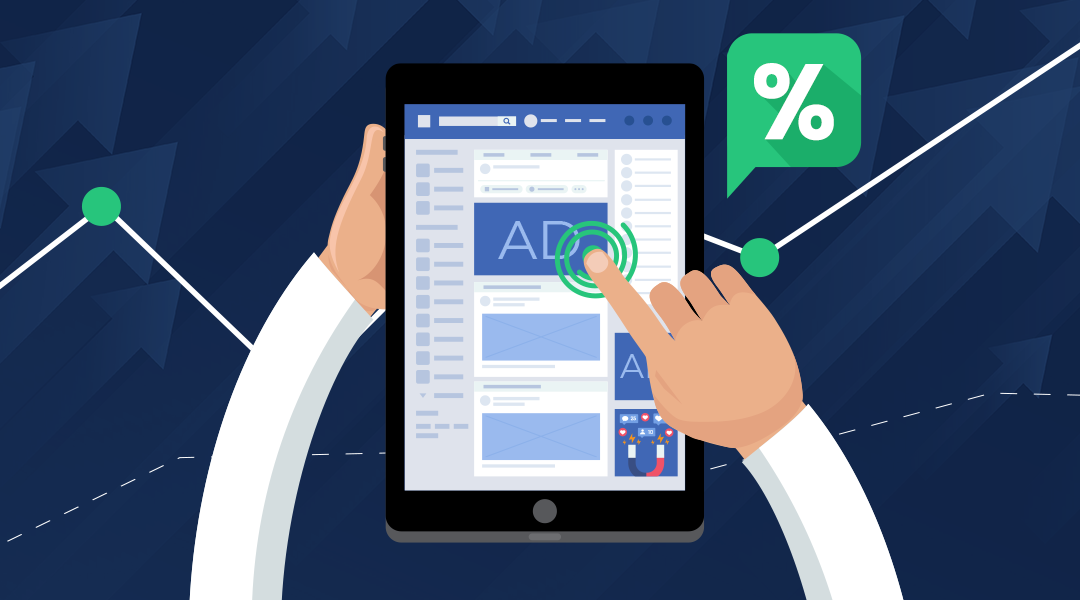

### KDD stages:
The KDD (Knowledge Discovery in Databases) stages will occur according to the following figure




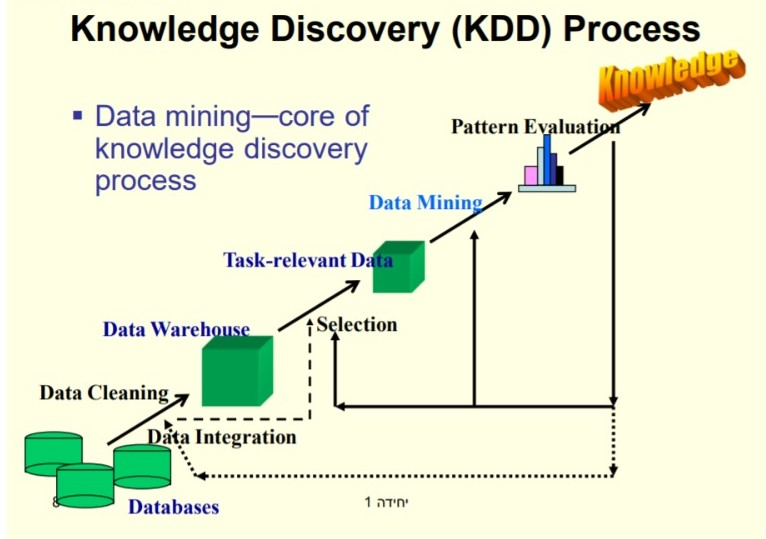

#Installations


In [7]:
!pip install TPOT

In [8]:
!pip3 install catboost

#Imports

Here we listed the main libraries used:


*   Numpy: Standard library for math operations on arrays
*   Pandas: Used to manipulate data inside dataframes and for basic computations
*   Sklearn: Used to apply different ML algorithms/models to the data
*   Matplotlib: Plot visualizations
*   Seaborn: Built on top of pyplot for nicer visualizations and easier plotting
*   Keras: Deep learning API written in Python, running on top of the machine learning platform TensorFlow allowing fast experimentation.
*   TPOT: AutoML library in python that optimizes ML pipelines using genetic programming.

*   SMOTE: Oversampling library that generates synthetic samples from the minority class.
It is used to obtain a synthetically class-balanced or nearly class-balanced training set, which is then used to train the classifier.

In [9]:
import warnings
def ignore_warn(*args,**kwargs):
  pass
warnings.warn = ignore_warn #ignore annoying warning from sklearn and seaborn 

In [10]:
# General
import pandas as pd
import numpy as np
import statsmodels.api as sm
from collections import Counter

# Debug
import pdb

# Plots 
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

# Scikit-Learn
import sklearn
from sklearn import tree
from sklearn import preprocessing
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve, train_test_split, GridSearchCV

# Imbalanced dataset
from imblearn.over_sampling import SMOTE

# Deep Learning
from keras import callbacks
from keras.layers import Dense, BatchNormalization, Dropout, LSTM
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

# Auto ML
from tpot import TPOTClassifier

In [11]:
random_state = 42

In [12]:
df = pd.read_csv('Junior_DS_home-exercise_raw-data_2021.csv')

#Dataset

In [13]:
df.head()

,dt,hr,publisher_id_md5,tag_id_md5,webpage_md5,domain_md5,user_agent,os,browser,ip_md5,city,state,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
0,2021-08-21,2,a5c1c94f6947bf7e9c1296061681f85e,0a4503d9a7996465ea226090ee7f3d2c,989fcad1435fb3a9130e7258265ab072,4418f45c75058a984aa1e9e55cdcbd7b,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,6d3f023811729eb62a548d91cb5de4c6,Honolulu,HI,2.0,728.0,90.0,1.0,0.013215,0.91,-1.0,0.0
1,2021-08-21,2,30d99b1e89be2a4f90c24df7652df5c8,b6f4b5808bf0ae55937d6a1c2bcf2e57,231f9d80be35bde77f5575f5bd3bef42,ddab5f19c67abff7b9664abcb3011839,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,CHROME92,a6c4374269e9ba4cf8377782ff452662,Tolleson,AZ,2.0,336.0,280.0,1.0,0.005450,0.61,1.0,0.0
2,2021-08-21,1,9b5187c93acaac0cb12475838c1a3888,37f07b1cc99272a163c7ae7ed95bcdfd,12110cb0c2d004614c3b31ce96254e3a,cc4f21a9f5f8ee2ff4053a9eb3221846,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,7cc8094f4469df7e12c0c60470e37f78,Arlington,TX,2.0,200.0,200.0,3.0,0.001672,0.56,-1.0,0.0
3,2021-08-21,1,89ba233487c434af8212fd3c89550c28,6839e98f304f1380ac001475ab0c7f30,7556f889d444a854a09639e3a38b50e3,b76eb71327ba080ed8fffacf1386c835,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,CHROME92,80648b01aad3abb46f06c88b47071989,NaN,MN,1.0,468.0,60.0,3.0,0.000585,0.43,-1.0,0.0
4,2021-08-21,1,d9741e0c9d1029615161d7cf14987bd3,8ac1d8fd1a6d8ef055ac7afc96d63902,91d201dbde18cc37b505d5100c96102d,74add3c7d6dab3a1b6a82919192b2f1d,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,0969dc27996adb403816d85a91958642,Tucson,AZ,1.0,300.0,250.0,3.0,0.001885,0.71,-1.0,0.0


In [14]:
df.dtypes

dt                   object
hr                    int64
publisher_id_md5     object
tag_id_md5           object
webpage_md5          object
domain_md5           object
user_agent           object
os                   object
browser              object
ip_md5               object
city                 object
state                object
auction_type        float64
banner_width        float64
banner_height       float64
banner_position     float64
ctr                 float64
viewability         float64
session_depth       float64
clicks              float64
dtype: object

#EDA

checking unique values for each column

In [15]:
for col in df:
  print(f'number of unique values of {col}:', df[col].nunique())

number of unique values of dt: 15
number of unique values of hr: 24
number of unique values of publisher_id_md5: 1147
number of unique values of tag_id_md5: 2131
number of unique values of webpage_md5: 13713
number of unique values of domain_md5: 2440
number of unique values of user_agent: 674
number of unique values of os: 9
number of unique values of browser: 60
number of unique values of ip_md5: 23575
number of unique values of city: 4092
number of unique values of state: 51
number of unique values of auction_type: 2
number of unique values of banner_width: 7
number of unique values of banner_height: 6
number of unique values of banner_position: 4
number of unique values of ctr: 8254
number of unique values of viewability: 72
number of unique values of session_depth: 111
number of unique values of clicks: 2


lets explore more the object variables

In [16]:
object_variables = ['publisher_id_md5', 'tag_id_md5', 'webpage_md5','domain_md5','user_agent','os','browser','ip_md5','city','state']  
df[object_variables].describe(include=['O'])  

,publisher_id_md5,tag_id_md5,webpage_md5,domain_md5,user_agent,os,browser,ip_md5,city,state
count,26507,26507,26484,26484,26507,26507,26507,26507,22652,26498
unique,1147,2131,13713,2440,674,9,60,23575,4092,51
top,d9741e0c9d1029615161d7cf14987bd3,c4a5e0ff6f977b417533ff325393cdc2,4749a05f0ea21f5b048bc494a32f7682,91f6153240139a3b9ba22732798a2842,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,CHROME92,bd3901aed67b77ff63eb17f89871ed90,Chicago,TX
freq,1449,618,336,1271,5574,16765,7802,32,288,2590


As we can see from the table above that almost all the values in column "ip_md5" is unique, while the "publisher" column for example is not at all. There are too many unique elements within the ip_column and it is generally difficult to perform a prediction without the existence of a data pattern. Because of that, it will be omitted from further analysis. and we can assume that there aren't element of Time Series for infividual user. because each user is shown once.

In [17]:

df = df.drop(['ip_md5'], axis=1)

##Note: Time interval is only in one month, so we will omit month and year, and will stay only with day number

In [18]:
df['dt'] = pd.to_datetime(df['dt'])
df.insert(0, 'Day of month', df['dt'].dt.day)
df = df.drop(['dt'], axis=1)

In [19]:
df.head()

,Day of month,hr,publisher_id_md5,tag_id_md5,webpage_md5,domain_md5,user_agent,os,browser,city,state,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
0,21,2,a5c1c94f6947bf7e9c1296061681f85e,0a4503d9a7996465ea226090ee7f3d2c,989fcad1435fb3a9130e7258265ab072,4418f45c75058a984aa1e9e55cdcbd7b,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Honolulu,HI,2.0,728.0,90.0,1.0,0.013215,0.91,-1.0,0.0
1,21,2,30d99b1e89be2a4f90c24df7652df5c8,b6f4b5808bf0ae55937d6a1c2bcf2e57,231f9d80be35bde77f5575f5bd3bef42,ddab5f19c67abff7b9664abcb3011839,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,CHROME92,Tolleson,AZ,2.0,336.0,280.0,1.0,0.005450,0.61,1.0,0.0
2,21,1,9b5187c93acaac0cb12475838c1a3888,37f07b1cc99272a163c7ae7ed95bcdfd,12110cb0c2d004614c3b31ce96254e3a,cc4f21a9f5f8ee2ff4053a9eb3221846,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Arlington,TX,2.0,200.0,200.0,3.0,0.001672,0.56,-1.0,0.0
3,21,1,89ba233487c434af8212fd3c89550c28,6839e98f304f1380ac001475ab0c7f30,7556f889d444a854a09639e3a38b50e3,b76eb71327ba080ed8fffacf1386c835,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,CHROME92,NaN,MN,1.0,468.0,60.0,3.0,0.000585,0.43,-1.0,0.0
4,21,1,d9741e0c9d1029615161d7cf14987bd3,8ac1d8fd1a6d8ef055ac7afc96d63902,91d201dbde18cc37b505d5100c96102d,74add3c7d6dab3a1b6a82919192b2f1d,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Tucson,AZ,1.0,300.0,250.0,3.0,0.001885,0.71,-1.0,0.0


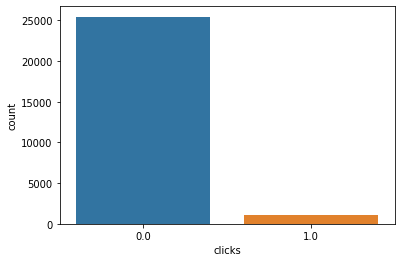

In [20]:
sns.countplot(x='clicks',data=df)

In [21]:
imp= df.groupby(['hr', 'clicks']).size().unstack()

In [22]:
imp

clicks,0.0,1.0
hr,,
0,484,13
1,377,10
2,262,7
3,220,4
4,245,5
5,314,3
6,485,14
7,824,29
8,1145,46


[]

<Figure size 432x288 with 0 Axes>

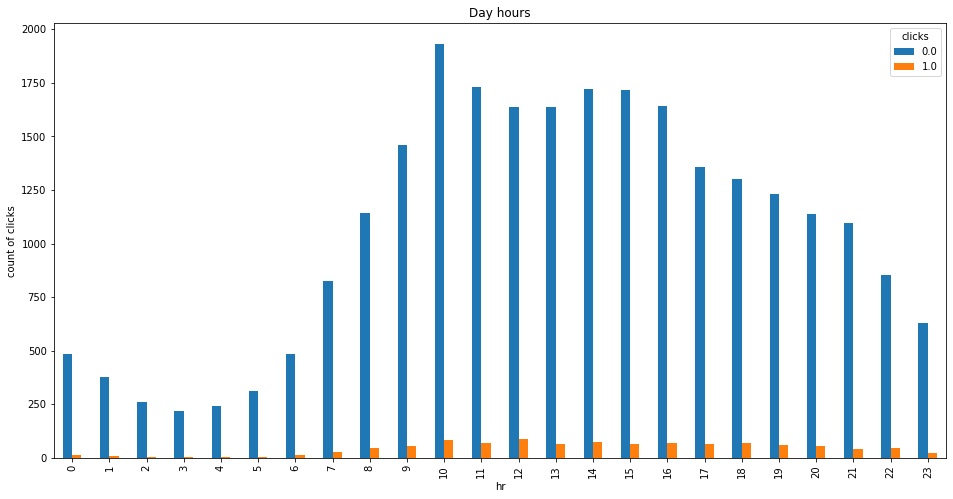

In [23]:
plt.figure()
imp.plot(kind='bar', title="Day hours", figsize=(16,8))
plt.ylabel("count of clicks")
plt.plot()

Here we can see the hourly impressions/day and we can clearly see that the rate of clicks is very low as compared to non clicks
this is the graph we also will see later.

In [24]:
df.groupby('banner_position')['clicks'].sum()

banner_position
1.0    558.0
3.0    507.0
5.0      0.0
6.0      2.0
Name: clicks, dtype: float64

In [25]:
df.banner_position.unique()

array([ 1.,  3.,  5.,  6., nan])

we can see that the banners positions in places 1 and 3 are most clickable, we can already think that this feature is a strong one.

In [26]:
df.groupby('browser')['clicks'].sum()

browser
CHROME70       0.0
CHROME71       0.0
CHROME72       1.0
CHROME73       0.0
CHROME74       0.0
CHROME75       2.0
CHROME76      12.0
CHROME77       4.0
CHROME78       0.0
CHROME79       0.0
CHROME80       2.0
CHROME81       1.0
CHROME83       0.0
CHROME84       3.0
CHROME85       5.0
CHROME86       6.0
CHROME87      10.0
CHROME88      19.0
CHROME89      16.0
CHROME90      27.0
CHROME91     153.0
CHROME92     427.0
EDGE81         0.0
EDGE82         0.0
EDGE83         0.0
EDGE84         1.0
EDGE85         1.0
EDGE86         0.0
EDGE87         0.0
EDGE88         0.0
EDGE89         1.0
EDGE90         1.0
EDGE91         7.0
EDGE92       116.0
FIREFOX66      0.0
FIREFOX67      0.0
FIREFOX68      2.0
FIREFOX69      0.0
FIREFOX70      0.0
FIREFOX71      0.0
FIREFOX72      1.0
FIREFOX73      0.0
FIREFOX74      1.0
FIREFOX75      0.0
FIREFOX76      0.0
FIREFOX77      2.0
FIREFOX78     16.0
FIREFOX79      0.0
FIREFOX80      0.0
FIREFOX81      0.0
FIREFOX82      0.0
FIREFOX83      1.0
FIRE

probably, the most users exist in the latest version.

In [27]:
df.groupby('state')['clicks'].sum().sort_values(ascending=False)

state
TX    101.0
FL     84.0
NY     69.0
IL     60.0
NC     52.0
GA     40.0
OH     40.0
PA     36.0
VA     35.0
IN     34.0
TN     30.0
AZ     30.0
WA     28.0
MN     27.0
MA     26.0
MI     26.0
SC     23.0
OK     23.0
NJ     22.0
MO     21.0
CO     21.0
MD     20.0
AR     18.0
KS     18.0
LA     15.0
IA     14.0
WI     14.0
MS     14.0
OR     13.0
UT     12.0
AL     12.0
KY     11.0
NV     10.0
WV      8.0
HI      7.0
NE      6.0
CT      6.0
WY      5.0
ID      5.0
ME      5.0
NM      5.0
NH      3.0
RI      3.0
VT      3.0
AK      3.0
MT      2.0
ND      2.0
DC      2.0
SD      2.0
DE      1.0
CA      0.0
Name: clicks, dtype: float64

In [28]:
df.groupby('city')['clicks'].sum().sort_values(ascending=False)

city
New York            15.0
Chicago             13.0
Charlotte           10.0
Dallas               9.0
Houston              9.0
                    ... 
Northampton          0.0
North Versailles     0.0
North Vernon         0.0
North Tonawanda      0.0
Little Ferry         0.0
Name: clicks, Length: 4092, dtype: float64

In [29]:
df.head()

,Day of month,hr,publisher_id_md5,tag_id_md5,webpage_md5,domain_md5,user_agent,os,browser,city,state,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
0,21,2,a5c1c94f6947bf7e9c1296061681f85e,0a4503d9a7996465ea226090ee7f3d2c,989fcad1435fb3a9130e7258265ab072,4418f45c75058a984aa1e9e55cdcbd7b,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Honolulu,HI,2.0,728.0,90.0,1.0,0.013215,0.91,-1.0,0.0
1,21,2,30d99b1e89be2a4f90c24df7652df5c8,b6f4b5808bf0ae55937d6a1c2bcf2e57,231f9d80be35bde77f5575f5bd3bef42,ddab5f19c67abff7b9664abcb3011839,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,CHROME92,Tolleson,AZ,2.0,336.0,280.0,1.0,0.005450,0.61,1.0,0.0
2,21,1,9b5187c93acaac0cb12475838c1a3888,37f07b1cc99272a163c7ae7ed95bcdfd,12110cb0c2d004614c3b31ce96254e3a,cc4f21a9f5f8ee2ff4053a9eb3221846,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Arlington,TX,2.0,200.0,200.0,3.0,0.001672,0.56,-1.0,0.0
3,21,1,89ba233487c434af8212fd3c89550c28,6839e98f304f1380ac001475ab0c7f30,7556f889d444a854a09639e3a38b50e3,b76eb71327ba080ed8fffacf1386c835,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,CHROME92,NaN,MN,1.0,468.0,60.0,3.0,0.000585,0.43,-1.0,0.0
4,21,1,d9741e0c9d1029615161d7cf14987bd3,8ac1d8fd1a6d8ef055ac7afc96d63902,91d201dbde18cc37b505d5100c96102d,74add3c7d6dab3a1b6a82919192b2f1d,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Tucson,AZ,1.0,300.0,250.0,3.0,0.001885,0.71,-1.0,0.0


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26507 entries, 0 to 26506
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Day of month      26507 non-null  int64  
 1   hr                26507 non-null  int64  
 2   publisher_id_md5  26507 non-null  object 
 3   tag_id_md5        26507 non-null  object 
 4   webpage_md5       26484 non-null  object 
 5   domain_md5        26484 non-null  object 
 6   user_agent        26507 non-null  object 
 7   os                26507 non-null  object 
 8   browser           26507 non-null  object 
 9   city              22652 non-null  object 
 10  state             26498 non-null  object 
 11  auction_type      26506 non-null  float64
 12  banner_width      26506 non-null  float64
 13  banner_height     26506 non-null  float64
 14  banner_position   26503 non-null  float64
 15  ctr               26506 non-null  float64
 16  viewability       26506 non-null  float6

#Missing Values

In [31]:
df.isna().sum()

Day of month           0
hr                     0
publisher_id_md5       0
tag_id_md5             0
webpage_md5           23
domain_md5            23
user_agent             0
os                     0
browser                0
city                3855
state                  9
auction_type           1
banner_width           1
banner_height          1
banner_position        4
ctr                    1
viewability            1
session_depth          1
clicks                 1
dtype: int64

In [32]:
 df.dropna(inplace=True)

I didnt had enough time to explore Nans,install mean for each Nan, or predict the value with another model and so on, maybe I could transform them, but because I wanted to be able to solve the task given the times, I decided to get rid of them. 
we will see thats not big deal in terms of accuracy of the models.

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22627 entries, 0 to 26505
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Day of month      22627 non-null  int64  
 1   hr                22627 non-null  int64  
 2   publisher_id_md5  22627 non-null  object 
 3   tag_id_md5        22627 non-null  object 
 4   webpage_md5       22627 non-null  object 
 5   domain_md5        22627 non-null  object 
 6   user_agent        22627 non-null  object 
 7   os                22627 non-null  object 
 8   browser           22627 non-null  object 
 9   city              22627 non-null  object 
 10  state             22627 non-null  object 
 11  auction_type      22627 non-null  float64
 12  banner_width      22627 non-null  float64
 13  banner_height     22627 non-null  float64
 14  banner_position   22627 non-null  float64
 15  ctr               22627 non-null  float64
 16  viewability       22627 non-null  float6

In [34]:
df.isna().sum()

Day of month        0
hr                  0
publisher_id_md5    0
tag_id_md5          0
webpage_md5         0
domain_md5          0
user_agent          0
os                  0
browser             0
city                0
state               0
auction_type        0
banner_width        0
banner_height       0
banner_position     0
ctr                 0
viewability         0
session_depth       0
clicks              0
dtype: int64

In [35]:
df.describe()

,Day of month,hr,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
count,22627.000000,22627.000000,22627.000000,22627.000000,22627.000000,22627.000000,22627.000000,22627.000000,22627.000000,22627.000000
mean,15.092368,13.343041,1.766429,450.949750,245.849649,1.936182,-0.207610,0.677065,0.304017,0.040217
std,4.132308,5.381057,0.423111,225.596856,181.562960,1.072792,0.413016,0.275073,6.780093,0.196473
min,6.000000,0.000000,1.000000,120.000000,60.000000,1.000000,-1.000000,-1.000000,-1.000000,0.000000
25%,11.000000,10.000000,2.000000,300.000000,90.000000,1.000000,0.000000,0.520000,-1.000000,0.000000
50%,16.000000,13.000000,2.000000,336.000000,250.000000,1.000000,0.000935,0.730000,-1.000000,0.000000
75%,19.000000,17.000000,2.000000,728.000000,280.000000,3.000000,0.004359,0.880000,-1.000000,0.000000
max,21.000000,23.000000,2.000000,728.000000,600.000000,6.000000,0.262326,1.000000,275.000000,1.000000


#Feature distributions

# skewness along the index axis


In [36]:
df.skew(axis = 0, skipna = True)

Day of month       -0.112531
hr                 -0.319771
auction_type       -1.259494
banner_width        0.217676
banner_height       0.988681
banner_position     0.610295
ctr                -1.394099
viewability        -2.842025
session_depth      14.883096
clicks              4.680774
dtype: float64

In [37]:
target = 'clicks'
numerical_features = ['banner_width','banner_height','ctr','viewability','session_depth']

#Outliers Detection
Tukey method is a single-step multiple comparison procedure and statistical test.

It can be used to find means that are significantly different from each other.

It's a statistical tool used to determine if the relationship between two sets of data is statistically significant – that is, whether there's a strong chance that an observed numerical change in one value is causally related to an observed change in another value.

In other words, the Tukey method is a way to test an experimental hypothesis.

In [38]:
def detect_outliers(df, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers  




In [39]:
rows_with_more_than_0_outlier = detect_outliers(df, 0 ,numerical_features)

In [40]:
rows_with_more_than_1_outlier = detect_outliers(df, 1 ,numerical_features)

Since outliers can have a dramatic effect on the prediction (espacially for regression problems), we chose to manage them.

Tukey method detects ouliers by defining an interquartile range comprised between the 1st and the 3rd quartile of the distribution values (IQR).

An outlier is a row that have a feature value outside (IQR +- an outlier step).

In [41]:
df.loc[rows_with_more_than_0_outlier]

,Day of month,hr,publisher_id_md5,tag_id_md5,webpage_md5,domain_md5,user_agent,os,browser,city,state,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
10,21,0,5fc291bff01b78c5f453a8e77cc2cfa3,9b1674c281218a5991163edaf8f127f4,01e599a13705d8199aef7aa5a5d4c04c,c7d37c0e21b8c99868344dfc78887318,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Junction City,OR,2.0,160.0,600.0,1.0,0.011989,0.91,-1.0,0.0
11,21,0,c2017bd8484d1bb6396b8e0dd2e6fa1d,0384b838e719b4170237c4918ac96b3b,e5a120f5aa3da562da7d1fded6a6048c,da1fdd00470294cf49a0790c7934d945,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Rainier,OR,2.0,120.0,600.0,1.0,0.008560,0.92,-1.0,0.0
13,21,5,37883f5499bda87ab6510ac03600b0d7,f208bcea6e6d81e935aef4f26f087885,c7d34e739173d22a63c2c5741830b755,8c67a5e874a7d134faddcce6876e63c5,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Muncie,IN,2.0,160.0,600.0,3.0,0.000412,0.87,-1.0,0.0
21,21,4,df07e2a2cf7134d81299d8c14834f018,42acfdc55e1193b977461be9af1cb0d8,164444f3294595f2e5f529d3764a23e1,4331d8ff9185c964811670e6e47c2c7b,Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:9...,WINDOWS_10,FIREFOX91,Mason,OH,2.0,160.0,600.0,1.0,0.011431,0.96,-1.0,0.0
43,21,0,1a110241d72b28a1d7be22d3fc9f2712,84422a2182d751042e5c5a3ae2e8352b,f2cf289c8d226f96207ebb98f1caef00,adc1cb7a6c231807480713da89957579,Mozilla/5.0 (Windows NT 10.0; WOW64; rv:68.0) ...,WINDOWS_10,FIREFOX68,Boulder,CO,2.0,160.0,600.0,1.0,0.000287,0.54,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26468,14,16,89ba233487c434af8212fd3c89550c28,cff4930350b3a4aae212ce09a85f1583,8c893d3d8083f8eb81dc7e2a87f00a01,003ca3177e1a19888f39dc770ffd1b12,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,EDGE92,Avondale,AZ,1.0,300.0,250.0,3.0,0.000055,0.36,1.0,0.0
26478,10,14,37c13d913ce62496a16b732cf3f85168,de0095f172035696bd86d888c09034a4,3570186786f5a5988c6f20bc21c199a0,2985e15c3c343b1271e4dcd6dd9895c0,Mozilla/5.0 (X11; CrOS x86_64 13904.97.0) Appl...,CHROME_OS,CHROME91,Durham,NC,2.0,336.0,280.0,3.0,0.000350,0.67,1.0,0.0
26490,11,15,c2017bd8484d1bb6396b8e0dd2e6fa1d,bd07fb64970513ebd1c5af7d4841fde2,596441374fbf4ced14fe267afdbab50a,da1fdd00470294cf49a0790c7934d945,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_6...,MAC_OS_X,CHROME92,Akron,PA,2.0,728.0,90.0,1.0,0.007983,0.98,1.0,0.0
26496,15,12,ed8c56ddaa375b47b56b614519e90d7c,260a50642818506b2cd14efcadf538d1,03ee56511a2a6ba10936362c14335fa8,91f6153240139a3b9ba22732798a2842,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,WINDOWS_10,CHROME92,Stuart,FL,1.0,468.0,60.0,3.0,0.000642,0.48,5.0,0.0


In [42]:
#df.loc[rows_with_more_than_1_outlier]

In [43]:
df_outliers = df.copy()
df = df.drop(rows_with_more_than_0_outlier, axis=0).reset_index(drop=True)

In [44]:
df.describe()

,Day of month,hr,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
count,9212.000000,9212.000000,9212.000000,9212.000000,9212.000000,9212.000000,9212.000000,9212.000000,9212.0,9212.000000
mean,15.345853,13.217651,1.719388,505.886235,172.354538,1.940947,0.002062,0.694969,-1.0,0.028116
std,4.293339,5.443471,0.449323,197.383821,90.781974,1.100127,0.002443,0.197415,0.0,0.165312
min,8.000000,0.000000,1.000000,200.000000,60.000000,1.000000,0.000000,0.300000,-1.0,0.000000
25%,11.000000,10.000000,1.000000,336.000000,90.000000,1.000000,0.000442,0.530000,-1.0,0.000000
50%,16.000000,13.000000,2.000000,468.000000,90.000000,1.000000,0.001018,0.720000,-1.0,0.000000
75%,19.000000,17.000000,2.000000,728.000000,250.000000,3.000000,0.002624,0.870000,-1.0,0.000000
max,21.000000,23.000000,2.000000,728.000000,280.000000,6.000000,0.010870,0.990000,-1.0,1.000000


In [45]:
df.skew(axis = 0, skipna = True)

Day of month      -0.212061
hr                -0.320146
auction_type      -0.976738
banner_width       0.161589
banner_height      0.076611
banner_position    0.735385
ctr                1.718212
viewability       -0.327536
session_depth      0.000000
clicks             5.710264
dtype: float64

we can see that the distribution of the label 'clicks' is very skewed, we will see that later in a plot.

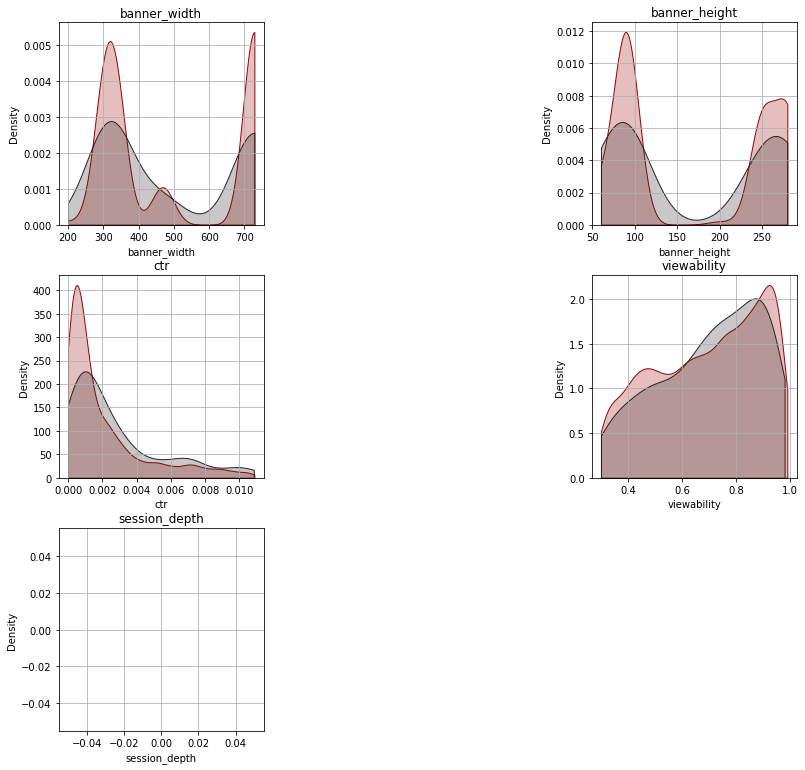

In [46]:
plt.figure(figsize=(18, 27))

for i, col in enumerate(numerical_features):
    plt.subplot(6, 4, i*2+1)
    plt.subplots_adjust(hspace =.25, wspace=.3)
    plt.grid(True)
    plt.title(col)
    sns.kdeplot(df.loc[df[target]==0, col], label="click", color = "#990303", shade=True, kernel='gau', cut=0)
    sns.kdeplot(df.loc[df[target]==1, col], label="noclick",  color = "#292323", shade=True, kernel='gau', cut=0)

We can see that actully banner_width values are very Dichotomic, also Session_depth, and banner_height.
and ctr is a little "right -skewed", so we may consider to normalize it by applying a log, and consider session depth as a categorical feature. 
and also considering binning "banner height&weight"

In [47]:
categorical_features = ['Day of month','session_depth','hr','auction_type','banner_position']

In [48]:
df['banner_position'] =  df['banner_position'].astype(int)

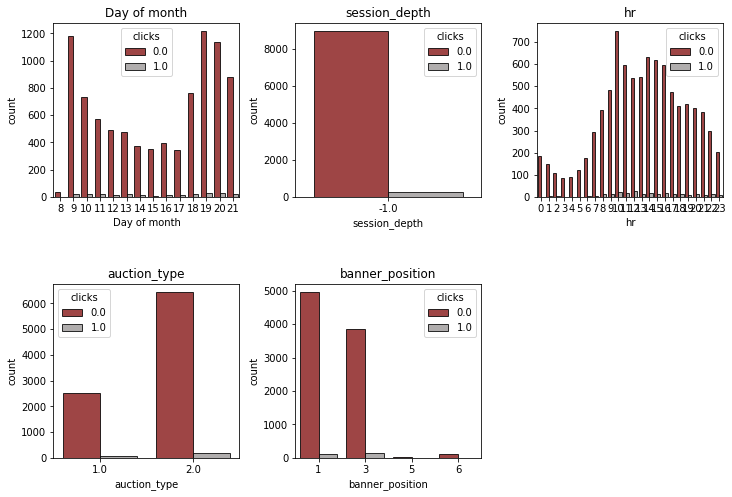

In [49]:
plt.figure(figsize=(12, 8))

for i, col in enumerate(categorical_features):
    plt.subplot(2, 3, i+1)
    plt.title(col)
    plt.subplots_adjust(hspace =.5, wspace=.3)
    sns.countplot(data=df, x=col, hue=target, palette = ["#990303", "#9C9999"], alpha=0.8, edgecolor="k", linewidth=1)

we can see from this charts , for example that the auction type, doesnt influencing so much on th enumber of clicks. because even though auction type is very big , it doesnt receive alot of clicks.
also , that there is a hours of pic with users, like around 10:00 - 12:00.
and so on. 

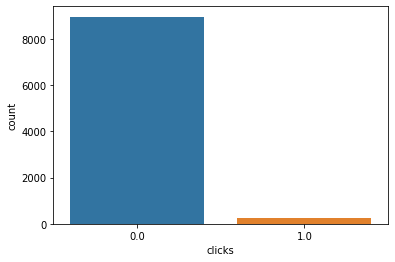

In [50]:
sns.countplot(df[target])

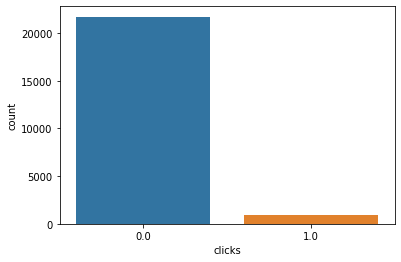

In [51]:
sns.countplot(df_outliers[target])

We can obviously see that out dataset is imbalaned so we need to balance the data - we'll do it using SMOTE which is the most popular way of balancing an imbalanced dataset.

# Correlation matrix

correlation matrix is simply a table which displays the linear relationships between each pair of features (including the target).

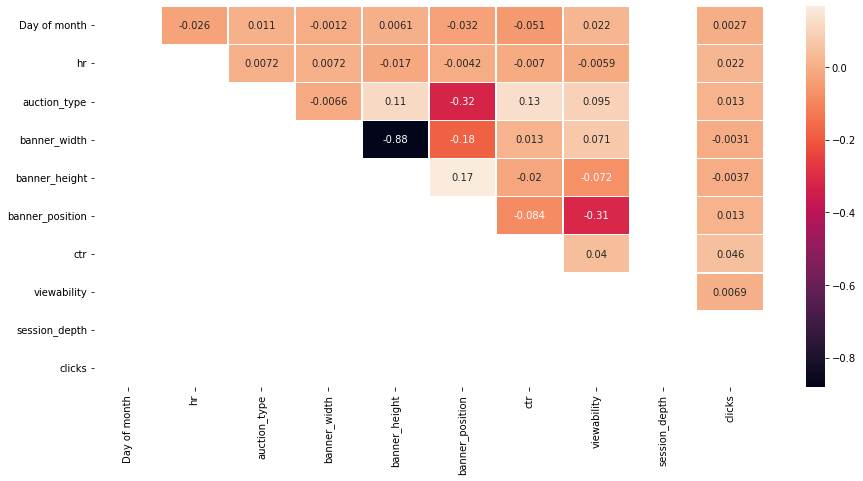

In [52]:
corr = df.corr()
matrix = np.tril(corr)
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(corr, annot=True, mask=matrix, linewidths=.5);

as we can see, there is a strong relation between viewbility to banner_position.
also between banner_height to banner_width, which is make sense of course.

#ONE HOT ENCODING

In [53]:
#for purpose of efficiency and because I need to upload the assignment soon, I will exlude publisher_id_md5,tag_id_m5,webpage_md5 
#, domain_md5,user_agent,city. otherwise the model after ONE-HOT encdoing on these feathers probably wont be able to perform good.
df = df.drop(['publisher_id_md5','tag_id_md5','webpage_md5','domain_md5','user_agent','city'], axis=1)
df_outliers = df_outliers.drop(['publisher_id_md5','tag_id_md5','webpage_md5','domain_md5','user_agent','city'], axis=1)

working right now only on outliers dataset


In [54]:
df

,Day of month,hr,os,browser,state,auction_type,banner_width,banner_height,banner_position,ctr,viewability,session_depth,clicks
0,21,1,WINDOWS_10,FIREFOX91,TX,2.0,200.0,200.0,3,0.001672,0.56,-1.0,0.0
1,21,1,WINDOWS_10,FIREFOX91,AZ,1.0,300.0,250.0,3,0.001885,0.71,-1.0,0.0
2,21,1,WINDOWS_10,FIREFOX91,NJ,2.0,728.0,90.0,1,0.003074,0.55,-1.0,0.0
3,21,3,WINDOWS_10,FIREFOX91,VA,2.0,336.0,280.0,3,0.005167,0.74,-1.0,0.0
4,21,5,WINDOWS_10,FIREFOX91,IL,2.0,728.0,90.0,1,0.000077,0.79,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9207,10,14,WINDOWS_10,EDGE92,NY,1.0,728.0,90.0,3,0.000985,0.34,-1.0,1.0
9208,11,15,MAC_OS_X,CHROME92,NY,1.0,300.0,250.0,3,0.002088,0.81,-1.0,0.0
9209,11,15,CHROME_OS,CHROME91,TX,2.0,728.0,90.0,1,0.002051,0.76,-1.0,0.0
9210,11,15,WINDOWS_10,CHROME92,TN,1.0,728.0,90.0,3,0.003495,0.42,-1.0,0.0


In [55]:
idx = 0 
df.insert(idx, 'banner_pos', df['banner_position'])
df = df.drop(columns=['banner_position'])

In [56]:
idx = 0 
df_outliers.insert(idx, 'banner_pos', df_outliers['banner_position'])
df_outliers = df_outliers.drop(columns=['banner_position'])

In [57]:
X_outliers = df_outliers.drop(columns=target)
y_outliers = df_outliers[target]

In [58]:
X = df.drop(columns=target)
y = df[target]

In [59]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [60]:
features_to_encode = ['banner_pos','Day of month','hr','os','browser','state','auction_type']

In [61]:
for feature in features_to_encode:
    X = encode_and_bind(X, feature)

In [62]:
for feature in features_to_encode:
    X_outliers = encode_and_bind(X_outliers, feature)

#Normalization

We want to normalize the data because it will give us insights about which features are the most important for the regression, because the bigger the coefficient (weight) the more important the feature.

Without normalization, we would assume by mistake a big importance to a not important feature and a small importance to an important feature.

Also, it doesn't harm the accuracy of the decision tree.

We'll use Standard_scaler which standardizes features by removing the mean and scaling to unit variance

The standard score of a sample x is calculated as:

z = (x - u) / s

where u is the mean of the training samples or zero if with_mean=False, and s is the standard deviation of the training samples or one if with_std=False.

Executing train_test_split in the right timing!

In [63]:
def standard_scaler(X):
  #Set up a standard scaler for the features
  col_names = list(X.columns)
  s_scaler = preprocessing.StandardScaler()
  X_df= s_scaler.fit_transform(X)
  X_df = pd.DataFrame(X_df, columns=col_names)
  return X_df  

In [64]:
scaled_features = X.copy()
col_names =['banner_width','banner_height','ctr','viewability']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X[col_names] = features

In [65]:
print(X)

      banner_width  banner_height       ctr  ...  state_WI  state_WV  state_WY
0        -1.549787       0.304542 -0.159339  ...         0         0         0
1        -1.043132       0.855342 -0.072428  ...         0         0         0
2         1.125350      -0.907218  0.414451  ...         0         0         0
3        -0.860736       1.185822  1.271147  ...         0         0         0
4         1.125350      -0.907218 -0.812177  ...         0         0         0
...            ...            ...       ...  ...       ...       ...       ...
9207      1.125350      -0.907218 -0.440691  ...         0         0         0
9208     -1.043132       0.855342  0.010723  ...         0         0         0
9209      1.125350      -0.907218 -0.004189  ...         0         0         0
9210      1.125350      -0.907218  0.586606  ...         0         0         0
9211      1.125350      -0.907218  0.877625  ...         0         0         0

[9212 rows x 117 columns]


In [66]:
scaled_features = X_outliers.copy()
col_names =['banner_width','banner_height','ctr','viewability']
features = scaled_features[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
X_outliers[col_names] = features

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state, stratify=y)

In [68]:
X_train_outliers, X_test_outliers, y_train_outliers, y_test_outliers = train_test_split(X_outliers, y_outliers, test_size=0.2, random_state=random_state, stratify=y_outliers)

# SMOTE
Imbalanced classification involves developing predictive models on classification datasets that have a severe class imbalance.

The challenge of working with imbalanced datasets is that most machine learning techniques will ignore, and in turn have poor performance on, the minority class, although typically it is performance on the minority class that is most important and in our case is the number of deads from heart failure.

One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

In this reserach proposal, we will use SMOTE for oversampling imbalanced classification datasets.

explanation has been taken from - https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

SMOTE works by utilizing a k-nearest neighbor algorithm to create synthetic data.

SMOTE first start by choosing random data from the minority class, then k-nearest neighbors from the data are set.

Synthetic data would then made between the random data and the randomly selected k-nearest neighbor.

In [69]:
def oversample_features_target(X, y):
  return SMOTE(random_state=random_state, n_jobs=-1, k_neighbors=5).fit_resample(X, y)

In [70]:
X_train_outliers_smote, y_train_outliers_smote = oversample_features_target(X_train_outliers, y_train_outliers)

In [71]:
X_train_nooutliers_smote , y_train_nooutliers_smote = oversample_features_target(X_train, y_train)

In [72]:
# important lines
X_train_nooutliers_smote = pd.DataFrame(np.matrix(X_train_nooutliers_smote),columns=X.columns)
X_train_outliers_smote = pd.DataFrame(np.matrix(X_train_outliers_smote),columns=X_outliers.columns)

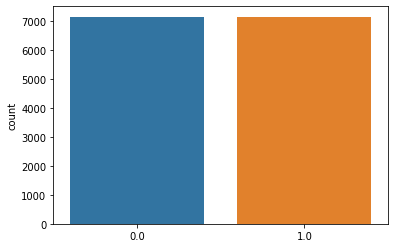

In [73]:
sns.countplot(y_train_nooutliers_smote)

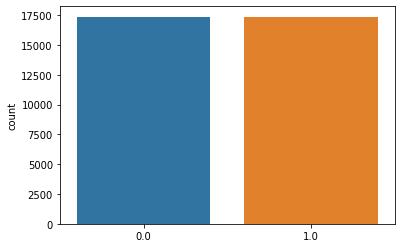

In [74]:
sns.countplot(y_train_outliers_smote)

Now we can see the data is balanced so SMOTE worked!

In [75]:
X_train_nooutliers_smote.head(5)

,banner_width,banner_height,ctr,viewability,session_depth,os_CHROME_OS,os_MAC_OS_X,os_UNKNOWN,os_WINDOWS_10,os_WINDOWS_7,os_WINDOWS_8,os_WINDOWS_81,os_WINDOWS_VISTA,os_WINDOWS_XP,browser_CHROME72,browser_CHROME73,browser_CHROME74,browser_CHROME75,browser_CHROME76,browser_CHROME77,browser_CHROME78,browser_CHROME79,browser_CHROME80,browser_CHROME81,browser_CHROME83,browser_CHROME84,browser_CHROME85,browser_CHROME86,browser_CHROME87,browser_CHROME88,browser_CHROME89,browser_CHROME90,browser_CHROME91,browser_CHROME92,browser_EDGE83,browser_EDGE84,browser_EDGE85,browser_EDGE87,browser_EDGE89,browser_EDGE90,...,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_RI,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY
0,-1.043132,0.855342,-0.026088,-1.848837,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.860736,1.185822,-0.332171,1.291924,-1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.860736,1.185822,-0.750733,-0.025169,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.125350,-0.907218,0.263101,0.886665,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.191952,-1.237698,0.385372,-0.886346,-1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#CAT_classifier

In [76]:
from catboost import CatBoostClassifier

In [77]:
cat_boost= CatBoostClassifier(learning_rate=0.05, loss_function='Logloss', 
                             random_state=123, iterations=100, eval_metric="Logloss")

In [78]:
cat_boost.fit(X_train_outliers_smote, y_train_outliers_smote, eval_set=(X_test_outliers, y_test_outliers), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6691098	test: 0.6801669	best: 0.6801669 (0)	total: 86.7ms	remaining: 8.59s
1:	learn: 0.6576920	test: 0.6684690	best: 0.6684690 (1)	total: 117ms	remaining: 5.73s
2:	learn: 0.6471256	test: 0.6573720	best: 0.6573720 (2)	total: 148ms	remaining: 4.78s
3:	learn: 0.6322279	test: 0.6478835	best: 0.6478835 (3)	total: 179ms	remaining: 4.3s
4:	learn: 0.6138233	test: 0.6378343	best: 0.6378343 (4)	total: 207ms	remaining: 3.94s
5:	learn: 0.6017108	test: 0.6284874	best: 0.6284874 (5)	total: 235ms	remaining: 3.68s
6:	learn: 0.5918349	test: 0.6205438	best: 0.6205438 (6)	total: 277ms	remaining: 3.67s
7:	learn: 0.5858251	test: 0.6128810	best: 0.6128810 (7)	total: 311ms	remaining: 3.58s
8:	learn: 0.5756332	test: 0.6052746	best: 0.6052746 (8)	total: 342ms	remaining: 3.46s
9:	learn: 0.5678163	test: 0.5986552	best: 0.5986552 (9)	total: 373ms	remaining: 3.36s
10:	learn: 0.5589252	test: 0.5909980	best: 0.5909980 (10)	total: 403ms	remaining: 3.26s
11:	learn: 0.5470485	test: 0.5846147	best: 0.5846147

In [79]:
c= cat_boost.get_feature_importance(prettified=True).sort_index(ascending=True)

In [80]:
y_pred_outliers_smote= cat_boost.predict(X_test_outliers, prediction_type="Class", ntree_start=0, ntree_end= cat_boost.get_best_iteration(),thread_count=-1, 
                               verbose=None)

In [81]:
print(accuracy_score(y_pred_outliers_smote,y_test_outliers))

0.9405656208572691


#**Feature importance of tree based classifiers**

In order to see the most informative features for the prediction of clicks we displayed the feature importance for the upcoming trees.

[4.82460542e-02 4.69798310e-02 8.15926901e-02 9.03595765e-02
 3.20590690e-02 2.73807392e-02 1.42821622e-02 1.97324589e-05
 2.57202239e-02 7.65340466e-03 1.46021137e-03 5.10900802e-03
 2.05862638e-05 7.13268294e-05 1.09867856e-05 1.36650041e-05
 4.99778393e-04 1.57170369e-05 4.73583380e-05 1.34119455e-03
 2.86048526e-03 5.97325053e-04 1.28404706e-04 1.52864461e-04
 3.77364740e-04 2.06924727e-04 3.81048030e-04 1.23159581e-03
 1.16215117e-03 1.93399320e-03 1.85487562e-03 3.56217234e-03
 2.95337432e-03 6.56104778e-03 1.69665636e-02 4.52656175e-02
 1.23770034e-06 1.44338263e-06 1.41857057e-06 6.32809405e-04
 6.31796293e-04 1.07235314e-06 2.67107777e-05 1.53944756e-05
 4.70887695e-04 4.69545108e-04 1.36385109e-03 1.57294377e-02
 1.54143249e-06 4.08350793e-06 6.52986992e-04 1.59174263e-05
 2.60307727e-06 1.57124167e-05 5.66039562e-04 6.56402324e-06
 1.99082485e-05 1.21793808e-05 1.89747477e-05 1.50860722e-04
 3.58168376e-03 4.21673927e-05 2.55725020e-05 1.48479766e-05
 2.02754357e-05 3.761168

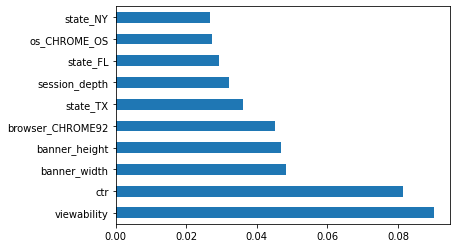

In [82]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train_outliers_smote,y_train_outliers_smote)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_outliers_smote.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

[4.86622612e-02 4.98170701e-02 7.92689409e-02 8.00229094e-02
 0.00000000e+00 1.91756631e-02 1.13000157e-02 2.24084419e-06
 2.71966182e-02 1.21097504e-02 1.41820459e-03 6.27301469e-03
 0.00000000e+00 0.00000000e+00 2.82881565e-05 3.63450316e-05
 1.76589960e-05 5.01555780e-04 1.53832537e-03 6.25922005e-04
 9.93006618e-05 1.27769820e-04 5.73922949e-05 6.54392875e-05
 7.00185586e-05 1.41436342e-04 1.91973117e-03 4.86417100e-04
 2.31246584e-03 1.60004501e-03 3.38807940e-03 4.08041311e-03
 1.25176651e-02 4.71539747e-02 1.72009162e-06 8.69936877e-05
 7.99729435e-06 8.37379510e-07 3.16893700e-04 1.79460621e-05
 2.84558186e-03 1.66473529e-02 0.00000000e+00 1.63932667e-04
 5.76113491e-05 0.00000000e+00 6.20330365e-05 1.42534235e-04
 2.80134696e-06 1.06918119e-05 4.21249293e-05 1.25815122e-05
 4.12799496e-03 8.62223698e-03 2.30673689e-05 7.67078876e-05
 9.35591441e-06 5.81022516e-05 2.90224793e-04 1.42319233e-04
 7.74364214e-04 8.40656310e-05 1.50538449e-04 1.80900776e-03
 4.14294357e-03 4.587250

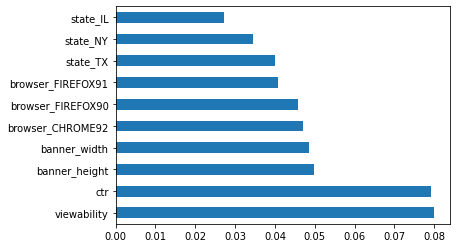

In [83]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X_train_nooutliers_smote,y_train_nooutliers_smote)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X_train_nooutliers_smote.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


## <font color='blue'>**Conclusion:  According to DecisionTreeClassifier,  the ctr,viewability are most important for predicting click, and then banner size, for both data set,even with outliers and with none !!.**</font>

##Base Models that has been chosen for the specific problem:
I chose **decision tree algorithms** and **Artifiical Neural Network**, descision trees because it is possible that the data does not necessarily have a linear relationship and therefore a decision tree can map it.


**Decision tree** is a prediction model that provides a mapping between observations and the appropriate values ​​for them,decision tree is a flow chart spring, in which each internal node (not a leaf) indicates a test on a feature, each branch represents a test result, and each leaf node holds a grade label. The highest node in a tree is the root A decision tree can be run so that the split is according to the Entropy Index (IG) or the Gini Index. it is not necessarily linear like logistic regression, we chose to use the Gini index because the entropy range ranges from 0 to 1 and the range of contamination in Gini ranges from 0 to 0.5. From this we can conclude that the impurity in Ginny is better compared to entropy for choosing the best features for splitting a junction

RANDOM FOREST

In [84]:
def print_accuracy_RF(X_train, y_train, X_test, y_test):
  clf = RandomForestClassifier(n_estimators=100)
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print("Accuracy:", accuracy_score(y_pred, y_test))

In [85]:
print_accuracy_RF(X_train_nooutliers_smote, y_train_nooutliers_smote, X_test, y_test)

Accuracy: 0.9658166033640803


In [86]:
print_accuracy_RF(X_train_outliers_smote, y_train_outliers_smote, X_test_outliers, y_test_outliers)

Accuracy: 0.9469730446310207



## <font color='red'>**Conclusion:  According to random forest, is better to remove outliers !!.**</font>

of course we under same random_state variable, so we need to take that into considiration

#XGBOOST Algorithm

In [87]:
from xgboost import XGBClassifier
model = XGBClassifier(tree_method = 'gpu_hist', n_jobs=-1, n_estimators=500, max_depth=11)
model.fit(X_train_nooutliers_smote,y_train_nooutliers_smote)
y_pred_nooutliers_smote = model.predict(X_test)

[19:54:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [88]:
print(accuracy_score(y_pred_nooutliers_smote,y_test))

0.9647314161692893


In [89]:
from xgboost import XGBClassifier
model = XGBClassifier(tree_method = 'gpu_hist', n_jobs=-1, n_estimators=500, max_depth=11)
model.fit(X_train_outliers_smote,y_train_outliers_smote)
y_pred_outliers_smote = model.predict(X_test_outliers)

[19:54:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [90]:
print(accuracy_score(y_pred_outliers_smote,y_test_outliers))

0.948519664162616


## <font color='red'>**Conclusion: According to XGBOOST, there was a need for removing outliers!!.**</font>

the right approch for tabular data set is to use Descision Tree Algorithms, as we know , and can be seen here also https://arxiv.org/abs/2106.03253
but I will use also Artificial Neural Network as another approach.

##Artificial Neural Network
how we build the model:

Initialising the ANN
Defining by adding layers
Compiling the ANN
Train the ANN

In [91]:
import tensorflow 
def generic_ANN( X,y,input_dim,min_delta=0,patience=10):
  early_stopping = callbacks.EarlyStopping(
      min_delta=min_delta,
      patience=patience,
      restore_best_weights=True)

  # Initialising the NN
  model = Sequential()
  optimizer = tensorflow.keras.optimizers.Adam(lr=0.01)
  # layers
  model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu', input_dim = input_dim))
  model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 16, kernel_initializer = 'uniform', activation = 'relu'))
  model.add(Dropout(0.5))
  model.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
  # Compiling the ANN
  model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

  # Train the ANN

  history = model.fit(X, y, batch_size = 32, verbose = 1, epochs = 100,callbacks=[early_stopping], validation_split=0.2) 
  return history , model 

Full run of AAN 

In [93]:
history_nooutliers_smote ,model_nooutliers_smote= generic_ANN(X_train_nooutliers_smote,y_train_nooutliers_smote,117)

Epoch 1/100
359/359 [==============================] - 5s 6ms/step - loss: 0.5832 - accuracy: 0.6462 - val_loss: 0.7434 - val_accuracy: 0.8206
Epoch 2/100
359/359 [==============================] - 2s 4ms/step - loss: 0.4863 - accuracy: 0.7302 - val_loss: 0.6320 - val_accuracy: 0.9016
Epoch 3/100
359/359 [==============================] - 2s 5ms/step - loss: 0.4285 - accuracy: 0.7827 - val_loss: 0.5166 - val_accuracy: 0.9138
Epoch 4/100
359/359 [==============================] - 2s 4ms/step - loss: 0.3849 - accuracy: 0.8158 - val_loss: 0.3790 - val_accuracy: 0.9818
Epoch 5/100
359/359 [==============================] - 2s 5ms/step - loss: 0.3474 - accuracy: 0.8433 - val_loss: 0.4891 - val_accuracy: 0.9372
Epoch 6/100
359/359 [==============================] - 2s 5ms/step - loss: 0.3204 - accuracy: 0.8576 - val_loss: 0.3092 - val_accuracy: 0.9839
Epoch 7/100
359/359 [==============================] - 2s 5ms/step - loss: 0.3130 - accuracy: 0.8673 - val_loss: 0.2765 - val_accuracy: 0.9832

In [94]:
history_outliers_smote , model_outliers_smote= generic_ANN(X_train_outliers_smote,y_train_outliers_smote,125)

Epoch 1/100
869/869 [==============================] - 5s 5ms/step - loss: 0.6436 - accuracy: 0.6247 - val_loss: 0.7987 - val_accuracy: 0.0000e+00
Epoch 2/100
869/869 [==============================] - 4s 4ms/step - loss: 0.6043 - accuracy: 0.6249 - val_loss: 0.8410 - val_accuracy: 0.0000e+00
Epoch 3/100
869/869 [==============================] - 4s 4ms/step - loss: 0.5640 - accuracy: 0.6364 - val_loss: 0.8200 - val_accuracy: 0.7694
Epoch 4/100
869/869 [==============================] - 4s 4ms/step - loss: 0.5394 - accuracy: 0.6724 - val_loss: 0.7265 - val_accuracy: 0.8754
Epoch 5/100
869/869 [==============================] - 4s 4ms/step - loss: 0.5197 - accuracy: 0.6939 - val_loss: 0.6890 - val_accuracy: 0.8778
Epoch 6/100
869/869 [==============================] - 4s 4ms/step - loss: 0.5039 - accuracy: 0.7093 - val_loss: 0.7664 - val_accuracy: 0.8560
Epoch 7/100
869/869 [==============================] - 4s 4ms/step - loss: 0.5001 - accuracy: 0.7131 - val_loss: 0.8282 - val_accuracy

In [95]:
def print_val_accuracy(history,type_of_data):
  val_accuracy = np.mean(history.history['val_accuracy'])
  print("\n%s: %.2f%%" % ('val_accuracy on ' + type_of_data+'', val_accuracy*100))

In [96]:
print_val_accuracy(history_nooutliers_smote,'nooutliersXsmote')


val_accuracy on nooutliersXsmote: 97.61%


In [97]:
print_val_accuracy(history_outliers_smote,'outliersXsmote')


val_accuracy on outliersXsmote: 88.00%


Plotting training and validation loss over epochs

In [98]:
def print_loss(history,type_of_data):
  history = pd.DataFrame(history.history)

  plt.plot(history.loc[:, ['loss']], "#6daa9f", label='Training loss')
  plt.plot(history.loc[:, ['val_loss']],"#774571", label='Validation loss')
  plt.title('Training and Validation loss on'+' '+type_of_data+' dataset')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc="best")

  plt.show()

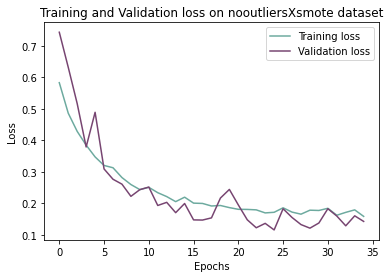

In [99]:
print_loss(history_nooutliers_smote,'nooutliersXsmote')

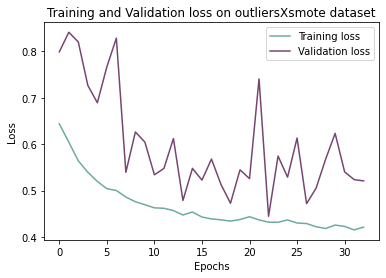

In [100]:
print_loss(history_outliers_smote,'outliersXsmote')

Plotting training and validation accuracy over epochs

In [101]:
def plot_accuracy(history,type_of_data):
  history = pd.DataFrame(history.history)

  plt.plot(history.loc[:, ['accuracy']], "#6daa9f", label='Training accuracy')
  plt.plot(history.loc[:, ['val_accuracy']], "#774571", label='Validation accuracy')

  plt.title('Training and Validation accuracy on '+ type_of_data)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

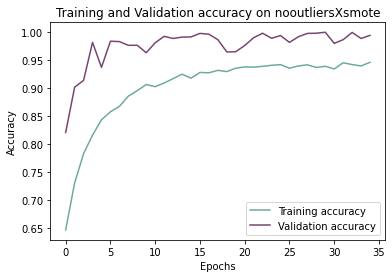

In [102]:
plot_accuracy(history_nooutliers_smote,'nooutliersXsmote')

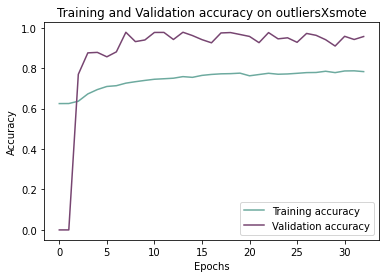

In [103]:
plot_accuracy(history_outliers_smote,'outliersXsmote')

In [104]:
def print_confusion_matrix_and_accuracy_score(model,X_test,y_test,type_of_data):
  y_pred = model.predict(X_test)
  y_pred = (y_pred > 0.5)
  np.set_printoptions()
  print('accuracy score on '+type_of_data+ ' is ' + str(accuracy_score(y_test,y_pred)))
  # confusion matrix
  cmap1 = sns.diverging_palette(275,150,  s=40, l=65, n=6)
  plt.subplots(figsize=(12,8))
  cf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(cf_matrix/np.sum(cf_matrix), cmap = cmap1, annot = True, annot_kws = {'size':15})

accuracy score on nooutliersXsmote is 0.8844275637547477


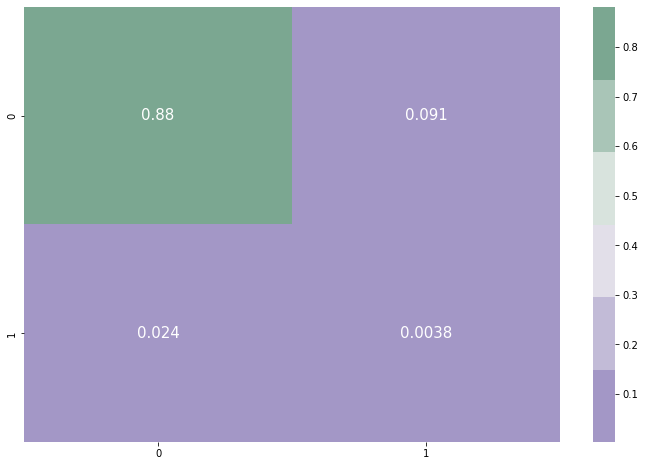

In [105]:
print_confusion_matrix_and_accuracy_score(model_nooutliers_smote,X_test,y_test,'nooutliersXsmote')

accuracy score on outliersXsmote is 0.672779496243924


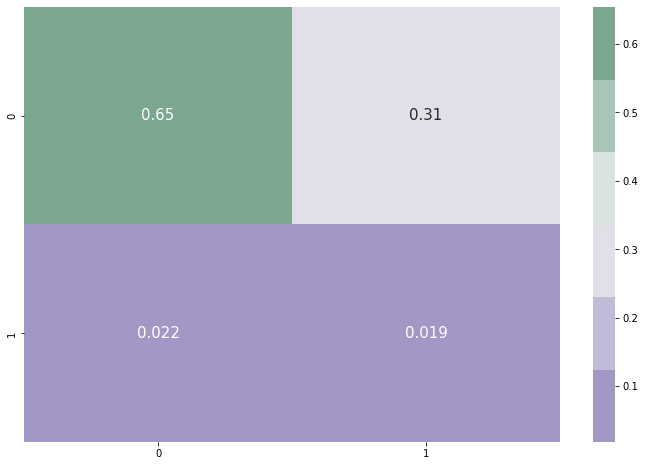

In [106]:
print_confusion_matrix_and_accuracy_score(model_outliers_smote,X_test_outliers,y_test_outliers,'outliersXsmote')

## <font color='red'>**Conclusion: According to ArtificialNeuralNetwork, dataset without outliers improved the accuracy significally.**</font>
(*under same hyperparameters)

#AutoML

TPOT is an AutoML library in python that optimizes ML pipelines using genetic programming.

Genetic Programming is an automatic programming technique that favors the evolution of computer programs that solve (or approximately solve) problems.

TPOT would also search for the best (accuracy wise) hyperparameters for us.

In [107]:
def run_tpot(X_train, y_train):
  tpot = TPOTClassifier(generations=None,
                      random_state=random_state, 
                      max_time_mins=60,
                      n_jobs=-1)
  tpot.fit(X_train, y_train)
  print(tpot.score(X_test, y_test))
  return tpot


The above method would run for 1 hour to find the best (accuracy wise) pipeline.

I ran this method for the dataset without the outliers, because I get a strong indication from the earlier algorithms that no outliers dataset perform best.

The result is in the following cells.



In [ ]:
#tpot_nooutliers_smote = run_tpot(X_train_nooutliers_smote, y_train_nooutliers_smote)

In [ ]:
#tpot_nooutliers_smote.export('tpot_exported_pipeline.py')

In [ ]:
#print(tpot_nooutliers_smote.score(X_test, y_test))

result on test is 96%

The pipe line that we recieve from Tipot after one hour of training is:

In [ ]:
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('PATH/TO/DATA/FILE', sep='COLUMN_SEPARATOR', dtype=np.float64)
features = tpot_data.drop('target', axis=1)
training_features, testing_features, training_target, testing_target = \
            train_test_split(features, tpot_data['target'], random_state=42)

# Average CV score on the training set was: 0.976322779570317
exported_pipeline = RandomForestClassifier(bootstrap=False, criterion="gini", max_features=0.35000000000000003, min_samples_leaf=6, min_samples_split=4, n_estimators=100)
# Fix random state in exported estimator
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)
"""

**lets run it!**

In [108]:
training_features, testing_features, training_target, testing_target = X_train_nooutliers_smote, X_test, y_train_nooutliers_smote , y_test
# Average CV score on the training set was: 0.976322779570317
exported_pipeline = RandomForestClassifier(bootstrap=False, criterion="gini", max_features=0.35000000000000003, min_samples_leaf=6, min_samples_split=4, n_estimators=100)
exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)


In [109]:
print(accuracy_score(results,y_test))

0.9647314161692893


we can see that AutoML via cross validation out performed every manual algorithm ,in the test(96%) and also in the train(97.6%)

#Conclusions:


* Regarding oversampling the data, according to all of our experiments, in general, SMOTE improved the accuracy (sometimes significantlly), or didn't harm it.

* Regarding outliers, according to all of our experiments, it's much better to run the model without the outliers than with them.


* the right approch for tabular data set is to use Descision Tree Algorithms, as 
we know , and can be seen here also https://arxiv.org/abs/2106.03253 but I used also Artificial Neural Network as another approach for comparison.


